In [7]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math 
torch.manual_seed(0)

In [16]:
def gaussian_log_pdf(z):
    """
    z: a batch of m data points (z dimension = m x data_dim)
    """
    return -0.5 * (torch.log(torch.tensor([math.pi*2], device=z.device)) + z **2  ).sum(1)

In [27]:
class PlanarFlow(nn.Module):
    """
    Used to contract and expand the density in the direction perpendicular to the 
    hyperplane w^T z+b = 0.
    
    """
    
    def __init__(self, data_dim):
        super().__init__()
        
        self.u = nn.Parameter(torch.rand(data_dim)) #extra parameter
        self.w = nn.Parameter(torch.rand(data_dim)) #weight 
        self.b = nn.Parameter(torch.rand(1))        #bais
        self.h = nn.Tanh()                          #actiavtion funciton
        self.h_prime = lambda z: (1- self.h(z)**2)
        
    def contrained_u(self):
        """
        Contrain the parameter u to ensure inveritibility
        """
        wu = torch.matmul(self.w.T, self.u)
        m = lambda x: -1 + torch.log(1+torch.exp(x))
        return self.u + (m(wu)-wu)*(self.w / (torch.norm(self.w)**2 + 1e-15))
    
    def forward(self, z):
        u = self.contrained_u()
        hidden_units = torch.matmul(self.w.T, z.T) + self.b    #Preceptron
        x = z + u.unsqueeze(0) * self.h(hidden_units).unsqueeze(-1)
        psi = self.h_prime(hidden_units).unsqueeze(0) * self.w.unsqueeze(-1)
        log_det = torch.log((1+ torch.matmul(u.T, psi)).abs() + 1e-15)
        return x, log_det
    
class NormalizingFlow(nn.Module):
    """
    We will stack planar Flow one on top of the other
    """
    def __init__(self, flow_length, data_dim):
        super().__init__()
        
        self.layers = nn.Sequential(
            *(PlanarFlow(data_dim) for _ in range(flow_length)))
        
    def forward(self, z):
        log_jacobians = 0
        for layer in self.layers:
            z, log_jacobian = layer(z)
            log_jacobians += log_jacobian
        return z, log_jacobians

    def train(flow, optimizer, nb_epochs, log_density, batch_size, data_dim):
        
        training_loss = []
        for epoch in tqdm(range(nb_epochs)):
            
            # Generate new sample from the flow
            z0 = torch.randn(batch_size, data_dim).to(device)
            zk, log_jacobian = flow(z0)
            
            # Evaluate the exact and approximated densities
            flow_log_density = gaussian_log_pdf(z0) - log_jacobian
            exact_log_density = log_density(zk).to(device)

            # compute loss
            reverse_kl_divergence = (flow_log_density - exact_log_density).mean()
            optimizer.zero_grad()
            loss = reverse_kl_divergence
            loss.backward()
            optimizer.step()

            training_loss.append(loss.item())
        return training_loss

In [28]:
def plot_flow_density(flow, ax, lims=np.array([[-4, 4], [-4, 4]]), cmap="coolwarm", title=None,
                      nb_point_per_dimension=1000):
    # Sample broadly from the latent space
    latent_space_boundaries = np.array([[-15, 15], [-15, 15]]);
    xx, yy = np.meshgrid(
        np.linspace(latent_space_boundaries[0][0], latent_space_boundaries[0][1], nb_point_per_dimension),
        np.linspace(latent_space_boundaries[1][0], latent_space_boundaries[1][1], nb_point_per_dimension))
    z = torch.tensor(np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1), dtype=torch.float)
    # Generate data points and evaluate their densities
    zk, log_jacobian = flow(z.to(device))
    final_log_prob = gaussian_log_pdf(z) - log_jacobian.cpu()
    qk = torch.exp(final_log_prob)

    ax.set_xlim(lims[0][0], lims[0][1]); ax.set_ylim(lims[1][0], lims[1][1])
    ax.pcolormesh(
        zk[:, 0].detach().data.cpu().reshape(nb_point_per_dimension, nb_point_per_dimension),
        zk[:, 1].detach().data.cpu().reshape(nb_point_per_dimension, nb_point_per_dimension) * -1,
        qk.detach().data.reshape(nb_point_per_dimension, nb_point_per_dimension),
        cmap=cmap,
        rasterized=True,
    )
    if title is not None:
        plt.title(title, fontsize=22)

def plot_exact_density(ax, exact_log_density, lims=np.array([[-4, 4], [-4, 4]]), nb_point_per_dimension=100,
                       cmap="coolwarm", title=None):
    xx, yy = np.meshgrid(np.linspace(lims[0][0], lims[0][1], nb_point_per_dimension),
                         np.linspace(lims[1][0], lims[1][1], nb_point_per_dimension))
    z = torch.tensor(np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1))
    density = torch.exp(exact_log_density(z)).reshape(nb_point_per_dimension, nb_point_per_dimension)
    ax.imshow(density, extent=([lims[0][0], lims[0][1], lims[1][0], lims[1][1]]), cmap=cmap)
    if title is not None:
        plt.title(title, fontsize=22)

### Energy function to test

In [29]:
w1 = lambda z: torch.sin((2 * np.pi * z[:, 0]) / 4)
w2 = lambda z: 3 * torch.exp(-(((z[:, 0] - 1) / 0.6) ** 2) / 2)
w3 = lambda z: 3 * 1 / (1 + torch.exp(- ((z[:, 0] - 1) / 0.3)))
# Energy functions
U1 = lambda z: (((torch.sqrt(z[:, 0] ** 2 + z[:, 1] ** 2) - 2) / 0.4) ** 2) / 2 - torch.log(
    1e-15 + (torch.exp(-(((z[:, 0] - 2) / 0.6) ** 2) / 2) + torch.exp(-(((z[:, 0] + 2) / 0.6) ** 2) / 2)))
U2 = lambda z: (((z[:, 1] - w1(z)) / 0.4) ** 2) / 2
U3 = lambda z: - torch.log(1e-15 + torch.exp(-(((z[:, 1] - w1(z)) / 0.35) ** 2) / 2) + torch.exp(
    -(((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2) / 2))
U4 = lambda z: - torch.log(1e-15 + torch.exp(-(((z[:, 1] - w1(z)) / 0.4) ** 2) / 2) + torch.exp(
    -(((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2) / 2))

## Train

  0%|                                                                             | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_4350/1426603116.py:21: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  wu = torch.matmul(self.w.T, self.u)
100%|█████████████████████████████████████████████████████████████████| 20000/20000 [03:26<00:00, 96.76it/s]
/tmp/ipykernel_4350/4215872609.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolorm

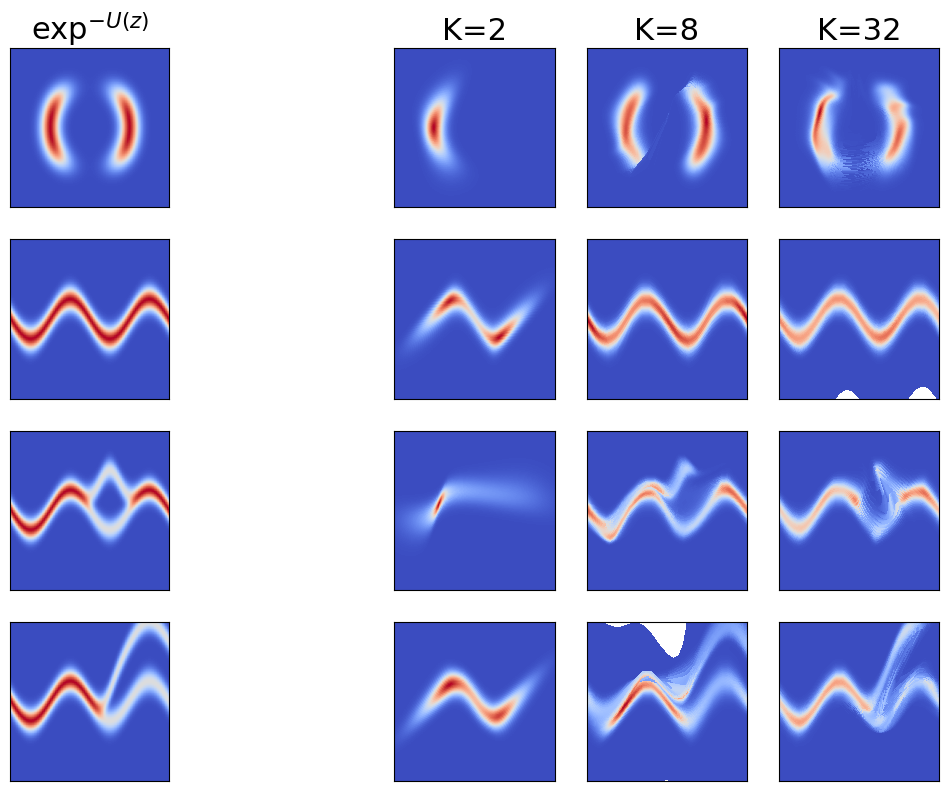

In [30]:
if __name__ == '__main__':
    device = 'cuda'
    data_dim = 2
    index = 1

    plt.figure(figsize=(12,12))
    for U in [U1, U2, U3, U4]:
        exact_log_density = lambda z: - U(z)
    
        # Plot the exact density
        ax = plt.subplot(5, 5, index); plt.xticks([], []); plt.yticks([], [])
        plot_exact_density(ax, exact_log_density, title=r'$\exp^{-U(z)}$' if index == 1 else None)
        index += 2
        
        #for each of the density  we train our model 
        for flow_length in [2, 8, 32]:
            flow = NormalizingFlow(flow_length, data_dim).to(device)
            optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
            loss = flow.train(optimizer, 20000, exact_log_density, 4096, data_dim)
            
            #plot the learned density
            ax = plt.subplot(5, 5, index); plt.xticks([], []); plt.yticks([], [])
            plot_flow_density(flow, ax, title=f'K={flow_length}' if index <= 5 else None)
            index += 1
    plt.show()
    
